# Fitting a symbolic regression for the edge messages learned for each edge (take the last epoch)

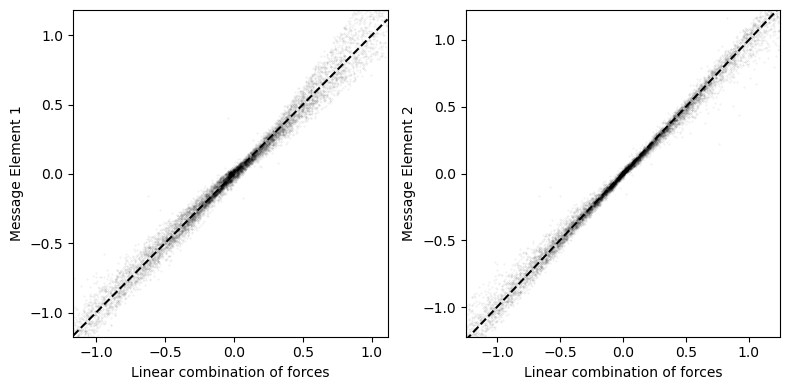

Fit parameters:  [-1.44963702e+00  4.20045423e-01 -2.61368568e-02 -5.12775366e-01
 -1.53589697e+00 -1.04032522e-03]
Most important message elements:  [61  3]
Most important message elements std:  [0.0572851  0.07341694]


In [12]:

# First let's plot the final epoch: message elements and linear combination of true forces

from pysr import PySRRegressor 
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import sys
import os
from analyze import linear_transformation_2d, out_linear_transformation_2d
from scipy.optimize import minimize


# Plot the learned message elements of the last epoch vs the linear combination (transformation) of true forces
msg_dim = 100
dim = 2
fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))


# Load the message data from the trained model - this also includes the node embedding for receiving and sending nodes
messages_over_time = pkl.load(open("models/messages_over_time.pkl", "rb"))

# Select the last element of the list corresponding to the final epoch
last_message = messages_over_time[-1]
last_message['bd'] = last_message.r + 1e-3


try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(last_message[msg_columns])
except:
    msg_columns = ['e%d'%(k) for k in range(msg_dim)]
    msg_array = np.array(last_message[msg_columns])
msg_importance = msg_array.std(axis=0)
most_important = np.argsort(msg_importance)[-dim:]
msgs_to_compare = msg_array[:, most_important]
msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)
pos_cols = ['dx', 'dy']

# Define the actual force function for the spring system
force_fnc = lambda msg: -(msg.bd.values - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd.values[:, None]
expected_forces = force_fnc(last_message)

min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')

for i in range(dim):
   
    px = out_linear_transformation_2d(min_result.x)[i]

    py = msgs_to_compare[:, i]
    ax[i].scatter(px, py,
                    alpha=0.1, s=0.1, color='k')
    ax[i].set_xlabel('Linear combination of forces')
    ax[i].set_ylabel('Message Element %d'%(i+1))

    xlim = np.array([np.percentile(px, q) for q in [10, 90]])
    ylim = np.array([np.percentile(py, q) for q in [10, 90]])
    xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
    ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
                
    plt.tight_layout()
    
# Plot a y=x line
for i in range(dim):
    ax[i].plot(ax[i].get_xlim(), ax[i].get_xlim(), 'k--')


plt.show()

# Extract the fit parameters for the most important message elements
print("Fit parameters: ", min_result.x)
print("Most important message elements: ", most_important)
print("Most important message elements std: ", msg_importance[most_important])




In [15]:
# Extract the fit parameters for the most important message elements
print("Fit parameters: ", min_result.x)


Fit parameters:  [-1.44963702e+00  4.20045423e-01 -2.61368568e-02 -5.12775366e-01
 -1.53589697e+00 -1.04032522e-03]


In [2]:
# Check the dimension of the messages_over_time
print(len(messages_over_time[0]))    # Should be equal to the number of epochs
print(messages_over_time[0]['train_loss'][:1][0])


print(type(messages_over_time[0]))    # Should be a dictionary
print(messages_over_time[0].keys())    # Should have the keys: 'loss', 'r', 'dx', 'dy', 'bd', 'e1', 'e2', ... 'e100'

12000
14.04633853474935
<class 'pandas.core.frame.DataFrame'>
Index(['x1', 'y1', 'vx1', 'vy1', 'q1', 'm1', 'x2', 'y2', 'vx2', 'vy2',
       ...
       'e96', 'e97', 'e98', 'e99', 'dx', 'dy', 'r', 'epoch', 'train_loss',
       'test_loss'],
      dtype='object', length=118)


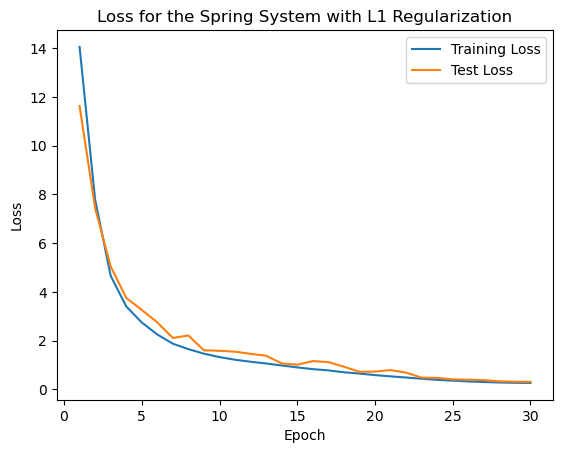

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# Extract the training loss values from each epoch
losses_train = [x['train_loss'][:1][0] for x in messages_over_time]
losses_test = [x['test_loss'][:1][0] for x in messages_over_time]

# Epochs
epochs = np.arange(1, len(losses_train)+1)

# Plot the training loss over time
# MAE loss of the batch of size train_batch_size over 30 epochs
plt.plot(epochs, losses_train, label='Training Loss')

# Plot the test loss over time
# MAE loss of the batch of size test_batch_size over 30 epochs
plt.plot(epochs, losses_test, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for the Spring System with L1 Regularization')
plt.legend()
plt.show()


In [5]:
# Create the symbolic regression model and train it
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    #unary_operators=["exp", "abs", "sqrt"],
    elementwise_loss="f(x, y) = abs(x - y)"
)


# Load the message data from the trained model - this also includes the node embedding for receiving and sending nodes
messages_over_time = pkl.load(open("models/messages_over_time.pkl", "rb"))

# Select the last element of the list corresponding to the final epoch
last_message = messages_over_time[-1]

# Find the most significant elements of the learned message vector
# Calculate the two with the largest standard deviation

# Calculate the standard deviations for each set of values
std_deviations = [np.std(messages_over_time[-1]['e%d' % i]) for i in range(100)]

# Sort the standard deviations in descending order and get the indices of the first two elements
best_indices = np.argsort(std_deviations)[::-1][:2]

# Extract the best messages
best_messages = last_message[['e%d'%(best_indices[0],), 'e%d'%(best_indices[1],), 'dx', 'dy', 'r', 'm1', 'm2']]

# Add small values to the r values to avoid division by zero
# best_messages['r'] = best_messages['r'] + 0.0001


best_messages[:13]




,e3,e61,dx,dy,r,m1,m2
0,0.054037,-0.002619,0.387275,1.452278,1.503028,2.868710,0.705558
1,-0.012341,-0.010106,0.734112,0.334981,0.806928,2.868710,0.672428
2,0.000123,0.000432,0.993327,-0.182153,1.009890,2.868710,0.681020
3,-0.061205,-0.001221,-0.387275,-1.452278,1.503028,0.705558,2.868710
4,-0.017031,0.005629,0.346837,-1.117297,1.169892,0.705558,0.672428
5,-0.070840,0.034607,0.606051,-1.634431,1.743176,0.705558,0.681020
6,0.012477,0.012032,-0.734112,-0.334981,0.806928,0.672428,2.868710
7,0.016591,-0.009805,-0.346837,1.117297,1.169892,0.672428,0.705558
8,0.033293,-0.020234,0.259214,-0.517134,0.578463,0.672428,0.681020
9,-0.000685,-0.004269,-0.993327,0.182153,1.009890,0.681020,2.868710


In [6]:
# Now, let's fir e39 and e65 as a function of dx, dy, r, m1, and m2

F1 = best_messages['e%d'%(best_indices[0],)]
F2 = best_messages['e%d'%(best_indices[1],)]

# First fit the highest standard deviation element
model.fit(best_messages[['dx', 'dy', 'r', 'm1', 'm2']], F1)


/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1877: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(


Compiling Julia backend...


[ Info: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (`options.batching`), and also if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form.
[ Info: Started!



Expressions evaluated per second: 1.600e+04
Head worker occupation: 7.8%
Progress: 45 / 1500 total iterations (3.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.434e+00  1.594e+01  y = -1.4346
3           3.279e-02  1.889e+00  y = 0.043031 * dy
5           2.454e-02  1.449e-01  y = 0.02635 * (dy * r)
7           2.221e-02  4.982e-02  y = 0.018832 * (dx + (dy * r))
9           2.070e-02  3.521e-02  y = 0.030744 * (((-0.72776 / r) + r) * dy)
11          1.616e-02  1.240e-01  y = ((r - (0.26692 + 0.7229)) * (dy / r)) * 0.11014
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.830e+04
Head worker occupation: 9.7%
Progress: 88 / 1500 total iterations (5.867%)
Hall of Fame:
-------------------------------------------------------

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -7.005647e-5   
	1        0.209783                                    dy * 0.04302671   
	2        0.150915                             (0.024430111 * r) * dy   
	3        0.104166                      ((r * dy) + dx) * 0.023287768   
	4        0.135650        r * (((0.32959455 * dx) + dy) * 0.02525381)   
	5        0.000681  r * (((0.32959455 * (dx - 0.02525381)) + dy) *...   
	6  >>>>  0.563163  (((dy - (-0.2703056 * dx)) / r) * (r - 0.99068...   
	7        0.138407  (((dy / r) + ((0.336297 / r) * dx)) * (r - 0.9...   
	8        0.002130  (((((0.336297 * dx) / r) + (dy / r)) - 0.00871...   
	9        0.006728  0.11055938 * ((r - 0.99068516) * ((dy / r) + (...   
	
	       loss  complexity  
	0  0.049882           1  
	1  0.032789           3  
	2  0.024247           5  
	3  0.019687           7  
	4  0.015009           9  
	5  0.014988          11  
	6  0.004860          13  
	7  0.003685          15  
	8  0.003669          17  
	9  0.003620          19  
]

In [7]:
print("The best symbolic formulation is found to be: ")
model.sympy()

The best symbolic formulation is found to be: 


0.11055938*(0.2703056*dx + dy)*(r - 0.99068516)/r

In [8]:
# Next fit the second highest standard deviation element
model.fit(best_messages[['dx', 'dy', 'r', 'm1', 'm2']], F2)


/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1843: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1877: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  w


Expressions evaluated per second: 6.490e+03
Head worker occupation: 9.8%
Progress: 28 / 1500 total iterations (1.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           2.421e-02  5.314e+00  y = 0.034162 * dx
7           1.718e-02  8.574e-02  y = 0.67981 * (0.030744 * (dx * r))
9           1.667e-02  1.507e-02  y = ((-0.092488 - (r / -1.5543)) * dx) * 0.030744
11          1.557e-02  3.428e-02  y = (dx * ((r + (-0.0024698 - 0.7131)) * 0.17462)) * 0.17462
13          1.278e-02  9.851e-02  y = 0.36345 * (-0.058602 * (((dx * r) * -0.92195) - (-0.46218 ...
                                  * dy)))
15          1.274e-02  1.554e-03  y = ((((0.12502 * (dy / -0.69138)) + dx) * r) * (0.2879 * 0.09...
                                  3103)) / 1.395
17          1.220e-02  2.166e-02  y = ((0.027049 - (r - 0.40486)) * ((-0.56756 * 0.027049) * (dx...
                                

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                      -0.0004343669   
	1        0.219276                                   0.034161672 * dx   
	2        0.179506                             dx * (r * 0.019330584)   
	3        0.042153              (0.029696995 * dx) * (r + -0.7200774)   
	4        0.178135        (0.085366085 * ((-0.9755407 + r) * dx)) / r   
	5        0.000850  (((-0.9754154 + r) * (dx - -0.0105614485)) * 0...   
	6  >>>>  0.462991  (((-0.9690326 + r) * ((dx / 0.2771007) - dy)) ...   
	7        0.001208  (((r + -0.9690326) * (((dx / 0.2771007) - dy) ...   
	8        0.001372  (0.029696995 * (((dx / 0.27912465) - dy) * ((r...   
	9        0.028060  (((-0.9677861 + r) * (((dx * (dx * 0.09668606)...   
	
	       loss  complexity  
	0  0.037539           1  
	1  0.024211           3  
	2  0.016908           5  
	3  0.015541           7  
	4  0.010883           9  
	5  0.010865          11  
	6  0.004304          13  
	7  0.004294          15  
	8  0.004282          17  
	9  0.004048          19  
]

In [9]:
print("The best symbolic formulation is found to be: ")
model.sympy()

The best symbolic formulation is found to be: 


0.022936026*(3.60879636897345*dx - dy)*(r - 0.9690326)/r